In [1]:
%cd MiniGPT-4

/home/jupyter/opthollm/MiniGPT-4


### Import Necessary Packages
Import minigpt4 and necessary helper libraries

In [8]:
#@title Import
import argparse
import os
import random

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import gradio as gr

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry
from minigpt4.conversation.multi_img_conversation import Chat, CONV_VISION

# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *
import matplotlib.pyplot as plt
import os

import argparse as argparse

### Helper Methods
Define helper methods including encode diagnosis 

In [3]:
#@title Methods
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", required=True, help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=2, help="specify the gpu to load the model.")
    parser.add_argument("--temperature", type=int, default=0.9, help="specify the gpu to load the model.")
    parser.add_argument("--english", type=bool, default=True, help="chinese or english")
    parser.add_argument("--prompt-en", type=str, default="can you describe the current picture?", help="Can you describe the current picture?")
    parser.add_argument("--prompt-zh", type=str, default="你能描述一下当前的图片？", help="Can you describe the current picture?")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args()
    return args


def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    cudnn.benchmark = False
    cudnn.deterministic = True


### fix this method since it's not completely accurate 

# determines if the LLM thinks the image is glaucomatous or not based on whether or not the text contains glaucomatous or not 
def encode_diagnosis(diagnosis):
    # could add: if contains glaucomatous and normal, then only look at first sentence
    
    if 'glaucomatous' in diagnosis.lower():
        return 1
    if 'normal' in diagnosis.lower():
        return 0
    else:
        return 2

# finds the true label of an image based on where it's stored in file path 
def fetch_ground_truth(img_path):
    split_string = img_path.split("/")

    # Find the index of "glaucoma" in the split string
    try:
        split_string.index("glaucoma")
        return 1
    except:
        return 0

# helper method that gets all files from a directory 
def get_all_files(directory):
    all_files = []
    
    # Iterate over all the directories and files within the given directory
    for root, directories, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            all_files.append(file_path)
    
    return all_files

def get_random_file(directory):
    all_files = get_all_files(directory)
    return random.choice(all_files)

### Initialize Model

In [6]:
print('Initializing Chat')
#args = parse_args()
#args = preset_args
args = argparse.Namespace(cfg_path='eval_configs/minigpt4_eval.yaml', gpu_id=0, num_beams=2, temperature=0.9, english=True, prompt_en='can you describe the current picture?', prompt_zh='你能描述一下当前的图片？', options=None)
cfg = Config(args)

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))

vis_processor_cfg = cfg.datasets_cfg.cc_sbu_align.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

print('Intializing Test')

Initializing Chat
Loading VIT
Loading VIT Done
Loading Q-Former
Loading Q-Former Done
Loading LLAMA

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading LLAMA Done
Load 4 training prompts
Prompt Example 
###Human: <Img><ImageHere></Img> Could you describe the contents of this image for me? ###Assistant: 
Load BLIP2-LLM Checkpoint: pretrained_minigpt4.pth
Initialization Finished
Intializing Test


### Test Few Shot Learning  

In [7]:
# store output

few_shot_data = {'img_path:': [],
                 'prediction:': [],
                 'ground_truth:': [],
                 'llm_message': []
                 }

# define examples for few shot learning

from chain_of_thought_imgs import img_descriptions
examples = img_descriptions.chain_of_thought_imgs

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27 │   │   max_length=2000                                                                     │
│   28 │   )[0]                                                                                    │
│   29                                                                                             │
│ ❱ 30 plt.imshow(image)                                                                           │
│   31 plt.show()                                                                                  │
│   32                                                                                             │
│   33                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py:2668 in imshow                      │
│                                                                                                  │
│   2665 │   │   alpha=None, vmin=None, vmax=None, origin=None, extent=None,                       │
│   2666 │   │   interpolation_stage=None, filternorm=True, filterrad=4.0,                         │
│   2667 │   │   resample=None, url=None, data=None, **kwargs):                                    │
│ ❱ 2668 │   __ret = gca().imshow(                                                                 │
│   2669 │   │   X, cmap=cmap, norm=norm, aspect=aspect,                                           │
│   2670 │   │   interpolation=interpolation, alpha=alpha, vmin=vmin,                              │
│   2671 │   │   vmax=vmax, origin=origin, extent=extent,                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/matplotlib/__init__.py:1442 in inner                     │
│                                                                                                  │
│   1439 │   @functools.wraps(func)                                                                │
│   1440 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1441 │   │   if data is None:                                                                  │
│ ❱ 1442 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1443 │   │                                                                                     │
│   1444 │   │   bound = new_sig.bind(ax, *args, **kwargs)                                         │
│   1445 │   │   auto_label = (bound.arguments.get(label_namer)                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5665 in imshow                  │
│                                                                                                  │
│   5662 │   │   │   │   │   │   │     interpolation_stage=interpolation_stage,                    │
│   5663 │   │   │   │   │   │   │     **kwargs)                                                   │
│   5664 │   │                                                                                     │
│ ❱ 5665 │   │   im.set_data(X)                                                                    │
│   5666 │   │   im.set_alpha(alpha)                                                               │
│   5667 │   │   if im.get_clip_path() is None:                                                    │
│   5668 │   │   │   # image does not already have clipping s

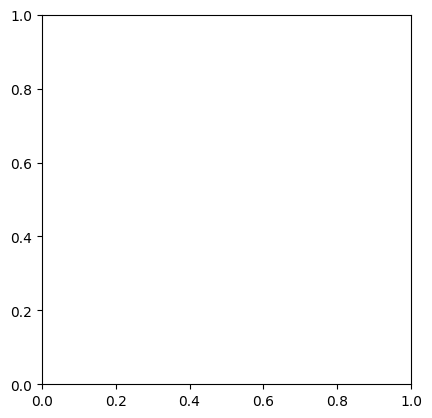

In [9]:
directory = 'RIM-ONE_DL_images/partitioned_randomly/training_set'
# pick random training image to test on

img_list = []
chat_state = CONV_VISION.copy()

image = get_random_file(directory)
few_shot_data['img_path:'].append(image)
few_shot_data['ground_truth:'].append(fetch_ground_truth(image))



# ask the prompt that has multiple examples (few shot inference)

#chat.embed_imgs([row[0] for row in examples], img_list)
#chat.embed_imgs([image], img_list)

chat.few_shot_learning_emb(chat_state, image, examples, img_list)

# have the model answer and display 
llm_message = llm_message = chat.answer(
        conv=chat_state,
        img_list=img_list,
        num_beams=args.num_beams,
        temperature=args.temperature,
        max_new_tokens=300,
        max_length=2000
    )[0]

plt.imshow(image)
plt.show()


few_shot_data['llm_message'].append(llm_message)
few_shot_data['prediction:'].append(encode_diagnosis(llm_message))

print(f"Img: {image} - Prediction: {few_shot_data['prediction:'][-1]} - Ground Truth: {few_shot_data['ground_truth:'][-1]} - LLM Message: {few_shot_data['llm_message'][-1]}")
  
print(chat_state)

In [6]:
directory = 'RIM-ONE_DL_images/partitioned_randomly/training_set'
# pick random training image to test on

img_list = []
chat_state = CONV_VISION.copy()

image = get_random_file(directory)
few_shot_data['img_path:'].append(image)
few_shot_data['ground_truth:'].append(fetch_ground_truth(image))



# ask the prompt that has multiple examples (few shot inference)

chat.upload_img(examples[0][0], chat_state, img_list)
chat.ask(f"Please diagnose the image as glaucomatous or normal. Diagnosis: {examples[0][1]}", conv=chat_state)
chat.upload_img(examples[1][0], chat_state, img_list)
chat.ask(f"Please diagnose the image as glaucomatous or normal. Diagnosis: {examples[1][1]}", conv=chat_state)
chat.upload_img(examples[2][0], chat_state, img_list)
chat.ask(f"Please diagnose the image as glaucomatous or normal. Diagnosis: {examples[2][1]}", conv=chat_state)
chat.upload_img(image, chat_state, img_list)
chat.ask(f"Please diagnose the image as glaucomatous or normal. Diagnosis: ", conv=chat_state)

# have the model answer and display 
llm_message = llm_message = chat.answer(
        conv=chat_state,
        img_list=img_list,
        num_beams=args.num_beams,
        temperature=args.temperature,
        max_new_tokens=300,
        max_length=2000
    )[0]

few_shot_data['llm_message'].append(llm_message)
few_shot_data['prediction:'].append(encode_diagnosis(llm_message))

print(f"Img: {image} - Prediction: {few_shot_data['prediction:'][-1]} - Ground Truth: {few_shot_data['ground_truth:'][-1]} - LLM Message: {few_shot_data['llm_message'][-1]}")
  

Img: RIM-ONE_DL_images/partitioned_randomly/training_set/normal/r1_Im063.png - Prediction: 2 - Ground Truth: 0 - LLM Message: 
